# Selecting model points by cluster analysis

This notebook applies cluster analysis to model point selection.
More specifically, we use the k-means method to partition a sample portfolio of seriatim policies and select representative model points.

As the sample portfolio, we use 10,000 seriatim term policies and their projection results, such as cashflows and present values of the cashflows. The sample policies are generated by a jupyter notebook included in the ``cluster`` library. The model used for generating the cashflows and present values are derived from ``BasicTerm_ME`` in the `basiclife` library, and included in the ``cluster`` library.

* What is the target use case?
* What should we look at to validate results?
* What should we use for *variables* ?
* What should the number of representative model points be?
* What initializataion method should we use for k-means?

**Target use case**

The target use case for this exercise is when we want to run deterministic projections of a large block of protection business under many different sensitivity scenarios. 

We construct a proxy portfolio based on the seriatim projection result of a base scenario by selecting and scaling representative polices. If the policy attributes of the proxy portfolio and projections results under the sensitivity scenarios obtained by using the proxy are close enough to those of the seriatim policies, then we can use the proxy portfolio for running the sensitivities and save time and computing resources.

In this exercise, we do not cover the cases where stochastic runs are involved. In reliaity, the stochastic cases would benefit more from the reduction in time and computing resources.


**Target metrics**

To determine how closely selected policies represents the seriatim policies, we look at the following figures:

* Net cashflows
* Policy attributes, such as issue age, policy term, sum assured and duration. 
* Presnet value of net cashflows and their components.

Among the above, the most important metric would be the present value of net cashflows, as it often represents the whole or a major part of insurance liabilities. 
In practice, the maximum allowable error in the estimation of the present value of cashflows should be specified (e.g. 1%).

**Choice of variables** 

The k-means method partitions samples based on squared Euclidean distances between samples. Samples are vectors of variable values.
What we choose for the variables has significant impact on the results. The chosen variables are more accurately estimated by the proxy portfolio. In this exercise, we test the following 3 types of variables and compare the results. 

* Net cashflows
* Policy attributes
* Present values of net cashflows and their components

Although not covered in this exercise, combinations of variables chosen across the 3 types above may yield better results. Further tests are left to subsequent studies.

**Reduction ratio**

Reduction ratio is defined as the number of seriatim policies devided by the number of selected representative model points.
The higher the ratio is, the more effective the proxy portfolio is. In this exercise, we select 1000 model points out of 10,000,
so the ratio in 10. The ratio and the accuracy of the proxy is a trade-off. Furthur tests beyond this exercise are desired to see how high the ratio we can get while maintaiing a certain level of accuracy. 


**Initialization method**

The k-means method returns diffrent outcomes depending on their initial values of cluster centroids. 
How to select the initial values is an area to be furthur explored, but in this exercise, we simply use the default method provided by sciki-learn.


*References:*

- [Gan, G. and Huang, J. (2017). A Data Mining Framework for Valuing Large Portfolios of Variable Annuities](http://library.usc.edu.ph/ACM/KKD%202017/pdfs/p1467.pdf)
- [Gan, G. and Valdez, E. A. (2019). Data Clustering with Actuarial Applications](https://deliverypdf.ssrn.com/delivery.php?ID=790086090127101095023064120110126117016083053010057028103075008126105105078103014074010017029060104024054109107072101085009103005023049082020120108076087100122100031019062051090024067099088106113090004110007127008101072121110098068079127127080025125064&EXT=pdf&INDEX=TRUE)
- [Goto, Y. A method to determine model points with cluster analysis, *Virtual ICA 2018*](https://www.actuview.com/video/A-method-to-determine-model-points-with-cluster-analysis/9084a36ba)
- [Milliman. Cluster analysis: A spatial approach to actuarial modeling](https://www.milliman.com/-/media/milliman/importedfiles/uploadedfiles/insight/research/life-rr/clusteranalysisaspatialrr080108pdf.ashx)


In [45]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, r2_score
import matplotlib.cm 
import matplotlib.pyplot as plt

## Sample Data

3 types of data are used, which are policy data, cashflow data and present value data. The policy data is in one file, while each of the other two consists of 3 sets of files, which correspond to the base, lapse-stress, and mortality-stress scenarios. 

The base cashflows and present values are used for calibration, while the cashflows and present values of the stressed scenarios are not.

### Cashflow Data

3 sets of cashflow data are read from Excel files into DataFrames. The DataFrames are assigned to these 3 global variables:

* `cfs`: The base scenario
* `csf_lapse50`: The stress scenario of 50% level increase in lapse rates
* `cfs_mort15`: The stress scenario of 15% level increase in mortality rates

In each file, net annual cashflows of the 10,000 sample policies are included. 
The files are outputs of `net_cf_annual` in `BasicTerm_ME_for_Cluster`.

In [46]:
cfs = pd.read_excel('cashflows_seriatim_10K.xlsx', index_col=0)
cfs_lapse50 = pd.read_excel('cashflows_seriatim_10K_lapse50.xlsx', index_col=0)
cfs_mort15 = pd.read_excel('cashflows_seriatim_10K_mort15.xlsx', index_col=0)
cfs_list = [cfs, cfs_lapse50, cfs_mort15]

The chart below compares the shapes of the 3 aggregated cashflows.

<AxesSubplot:title={'center':'Cashflows'}>

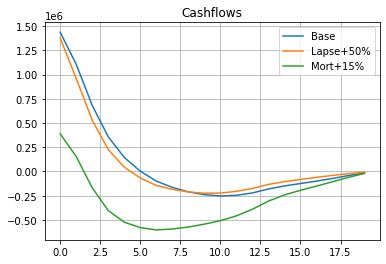

In [47]:
pd.DataFrame.from_dict({
    'Base': cfs.sum(), 
    'Lapse+50%': cfs_lapse50.sum(), 
    'Mort+15%': cfs_mort15.sum()}).plot(grid=True, title='Cashflows')

### Policy Data

Policy data is read from an Excel file into a DataFrame. In this sample case, 4 attributes completely defines a policy, so only the attributes are extracted as columns of the DataFrame. The DataFrame is then assigned to `pol_data`.  

In [48]:
pol_data = pd.read_excel(
    'BasicTerm_ME_for_Cluster/model_point_table.xlsx', index_col=0
)[['age_at_entry', 'policy_term', 'sum_assured', 'duration_mth']]
pol_data

,age_at_entry,policy_term,sum_assured,duration_mth
policy_id,,,,
1,47,10,622000,28
2,29,20,752000,213
3,51,10,799000,39
4,32,20,422000,140
5,28,15,605000,76
...,...,...,...,...
9996,47,20,827000,168
9997,30,15,826000,169
9998,45,20,783000,158


### Present Value Data

For each of the 3 scnarios, the present values of the net cashflowand their components are read from an Excel file into a DataFrame. The components are the present values of premiums, claims, expenses and commissions. The DataFrames are assigned to these 3 global variables:

* `pvs`: The base scenario
* `pvs_lapse50`: The stress scenario of 50% level increase in lapse rates
* `pvs_mort15`: The stress scenario of 15% level increase in mortality rates

In each file, net annual cashflows of the 10,000 sample policies are included. The files are outputs of `result_pv` in `BasicTerm_ME_for_Cluster`. The discount rate used is flat 3%.

In [49]:
pvs = pd.read_excel('pv_seriatim_10K.xlsx', index_col=0)
pvs_lapse50 = pd.read_excel('pv_seriatim_10K_lapse50.xlsx', index_col=0)
pvs_mort15 = pd.read_excel('pv_seriatim_10K_mort15.xlsx', index_col=0)
pvs_list = [pvs, pvs_lapse50, pvs_mort15]
pvs

,pv_premiums,pv_claims,pv_expenses,pv_commissions,pv_net_cf
policy_id,,,,,
1,5117.931213,3786.367310,278.536674,0.0,1053.027229
2,1563.198303,1733.892221,129.198252,0.0,-299.892170
3,8333.617576,6646.840127,270.360068,0.0,1416.417381
4,3229.275711,3098.020912,424.560625,0.0,-293.305825
5,3203.527395,2653.011845,401.855897,0.0,148.659654
...,...,...,...,...,...
9996,11839.037487,13872.879725,318.025035,0.0,-2351.867273
9997,662.104216,670.314857,54.077923,0.0,-62.288565
9998,10887.623809,12130.102842,356.697457,0.0,-1599.176490


## Python Code


`Clusters`, a class to facilitate the calibration process is defined below. 
The `Clusters` class wraps the fitted `KMeans` object which is calibrated using variables given as `loc_vars` through its initializer. 


We use the `KMeans` class imported from scikit-learn library in the initializer of the `Clusters` class.
The `fit` method on a `KMeans` object returns the object fitted using the local variables given to the method.

We use the `pairwise_distances_argmin_min` method from sckit-learn to find the samples closest to the centroids of the fitted `KMeans` object.

The `labels_` property of the fitted `KMeans` object holds cluster ID for each sample, indicating which cluster each sample belongs to.



In [50]:
class Clusters:
    
    def __init__(self, loc_vars):
        
        self.kmeans = kmeans = KMeans(n_clusters=1000, random_state=0).fit(np.ascontiguousarray(loc_vars))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, np.ascontiguousarray(loc_vars))
        
        rep_ids = pd.Series(data=(closest+1))   # 0-based to 1-based indexes
        rep_ids.name = 'policy_id'
        rep_ids.index.name = 'cluster_id'
        self.rep_ids = rep_ids
        
        self.policy_count = self.agg_by_cluster(pd.DataFrame({'policy_count': [1] * len(loc_vars)}))['policy_count']

    def agg_by_cluster(self, df, agg=None):
        """Aggregate columns by cluster"""
        temp = df.copy()
        temp['cluster_id'] = self.kmeans.labels_
        temp = temp.set_index('cluster_id')
        agg = {c: (agg[c] if c in agg else 'sum') for c in temp.columns} if agg else sum
        return temp.groupby(temp.index).agg(agg)
    
    def extract_reps(self, df):
        """Extract the rows of representative policies"""
        temp = pd.merge(self.rep_ids, df.reset_index(), how='left', on='policy_id')
        temp.index.name = 'cluster_id'
        return temp.drop('policy_id', axis=1)
    
    def extract_and_scale_reps(self, df, agg=None):
        """Extract and scale the rows of representative policies"""
        if agg:
            cols = df.columns
            mult = pd.DataFrame({c: (self.policy_count if (c not in agg or agg[c] == 'sum') else 1) for c in cols})
            return self.extract_reps(df).mul(mult)
        else:
            return self.extract_reps(df).mul(self.policy_count, axis=0)
    
    def compare(self, df, agg=None):
        """Returns a multi-indexed Dataframe comparing actual and estimate"""
        source = self.agg_by_cluster(df, agg)
        target = self.extract_and_scale_reps(df, agg)
        return pd.DataFrame({'actual': source.stack(), 'estimate':target.stack()})
    
    def compare_total(self, df, agg=None):            
        """Aggregate ``df`` by columns"""
        if agg:
            cols = df.columns
            op = {c: (agg[c] if c in agg else 'sum') for c in df.columns}
            actual = df.agg(op)
            estimate = self.extract_and_scale_reps(df, agg=op)
            
            op = {k: ((lambda s: s.dot(self.policy_count) / self.policy_count.sum()) if v == 'mean' else v) for k, v in op.items()}
            estimate = estimate.agg(op)
                        
        else:
            actual = df.sum()
            estimate = self.extract_and_scale_reps(df).sum()

        return pd.DataFrame({'actual': actual, 'estimate': estimate, 'error': estimate / actual - 1})

The functions below are for outputting plots.

In [51]:
def generate_subplots(count, shape):
    "Generator to output multiple charts in subplots"
    
    row_count, col_count = shape
    size_x, size_y = plt.rcParams['figure.figsize']
    size_x, size_y = size_x * col_count, size_y * row_count
    
    fig, axs = plt.subplots(row_count, col_count, figsize=(size_x, size_y))
    fig.tight_layout(pad=3)
    
    for i in range(count):
        r = i // col_count
        c = i - r * col_count
        ax = axs[r, c] if (row_count > 1 and col_count > 1) else axs[r] if row_count > 1 else axs[c] if col_count > 1 else axs
        ax.grid(True)
        yield ax


def plot_colored_scatter(ax, df, title=None):
    """Draw a scatter plot in different colours by level-1 index
    
    ``df`` should be a DataFrame returned by the compare method.
    """

    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(df.index.levels[1])))

    for y, c in zip(df.index.levels[1], colors):
        ax.scatter(df.xs(y, level=1)['actual'], df.xs(y, level=1)['estimate'], color=c, s=9)

    ax.set_xlabel('actual')
    ax.set_ylabel('estimate')
    if title:
        ax.set_title(title)
    ax.grid(True)
    draw_identity_line(ax)


def plot_separate_scatter(df, row_count, col_count):
    """Draw multiple scatter plot with R-squared
    
    ``df`` should be a DataFrame returned by the compare method.
    """
    names = df.index.levels[1]
    count = len(names)

    size_x, size_y = plt.rcParams['figure.figsize']
    size_x, size_y = size_x * col_count, size_y * row_count
    
    for i, ax in enumerate(generate_subplots(count, (row_count, col_count))):
        df_n = df.xs(names[i], level=1)
        df_n.plot(x='actual', y='estimate', kind='scatter', ax=ax, title=names[i], grid=True)
        draw_identity_line(ax)
        
        # Add R2 in upper left corner
        r2_x = 0.95 * ax.get_xlim()[0] + 0.05 * ax.get_xlim()[1]
        r2_y = 0.05 * ax.get_ylim()[0] + 0.95 * ax.get_ylim()[1]
        ax.text(r2_x, r2_y, 'R2: {:.1f}%'.format(calc_r2_score(df_n) * 100), verticalalignment='top')

        
def draw_identity_line(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'r-', linewidth=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    
def calc_r2_score(df):
    "Return R-squared between actual and estimate columns"
    return r2_score(df['actual'], df['estimate'])


## Cashflow Calibration

The first calibration approach we test is to use base annual cashflows as calibration variables.

In [52]:
cluster_cfs = Clusters(cfs)

### Cashflow Analysis

Below the total net cashflows under the base scenario are compared between `actual`, which denotes the total net cashflows of the seriatim sample policies, 
and `estimate`, which denots the total net cashflows calculated as the net cashflows of the selected representative policies multiplied by the numbers of policies in the clusters.

In [53]:
cluster_cfs.compare_total(cfs)

,actual,estimate,error
0,1.435932e+06,1.427125e+06,-0.006133
1,1.105742e+06,1.104242e+06,-0.001357
2,6.820530e+05,6.790717e+05,-0.004371
3,3.579056e+05,3.540011e+05,-0.010909
4,1.450520e+05,1.497167e+05,0.032159
5,3.343158e+03,1.154617e+04,2.453673
6,-9.917748e+04,-9.180151e+04,-0.074372
7,-1.636027e+05,-1.579898e+05,-0.034308
8,-2.099648e+05,-2.022847e+05,-0.036578
9,-2.391351e+05,-2.346361e+05,-0.018814


The charts below visualize how well the estimated cashflows match the actual.

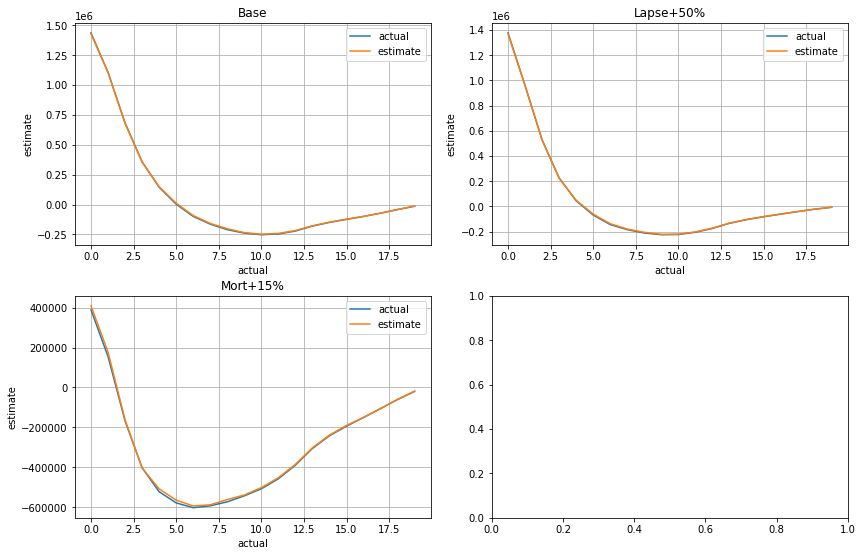

In [54]:
def plot_cashflows(ax, cfs, title=None):
    "Draw line plots of cashflows"
    cfs[['actual', 'estimate']].plot(ax= ax, grid=True, title=title, xlabel='actual', ylabel='estimate')

scen_titles = ['Base', 'Lapse+50%', 'Mort+15%']
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_cashflows(ax, cluster_cfs.compare_total(df), title)

The scatter charts below plots net annual cashflows by cluster. The read plots represent the nearest cashflows while violet plots are the farthest.

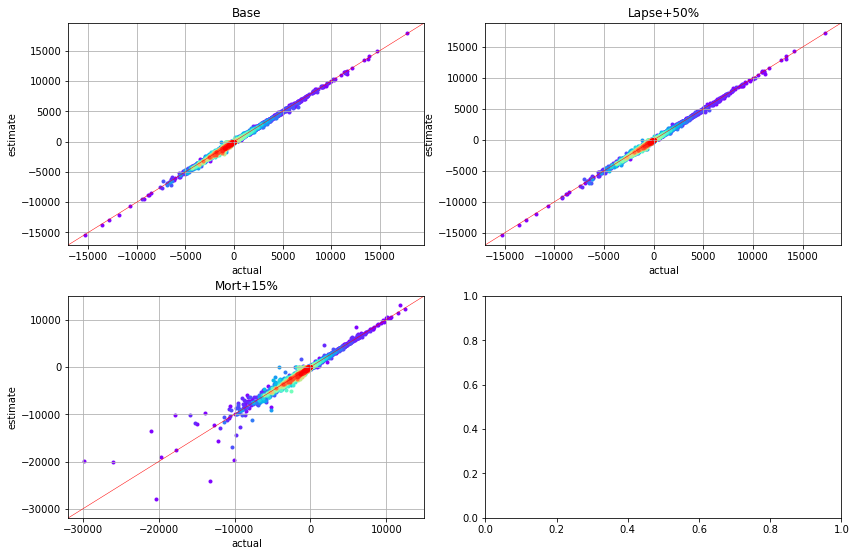

In [55]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_colored_scatter(ax, cluster_cfs.compare(df), title=title)

### Policy Attribute Analysis

In [56]:
mean_attrs = {'age_at_entry':'mean', 'policy_term':'mean', 'duration_mth':'mean'}
cluster_cfs.compare_total(pol_data, agg=mean_attrs)

,actual,estimate,error
age_at_entry,3.937720e+01,3.677740e+01,-0.066023
policy_term,1.493600e+01,1.541050e+01,0.031769
sum_assured,5.060517e+09,5.143883e+09,0.016474
duration_mth,8.977470e+01,9.594070e+01,0.068683


The charts below visualize how well the estimated policy attributes match the actual by cluster. The `age_at_entry`, `policy_term` and `duration_mth` charts plot the average of them in each cluster, while the `sum_assured` chart plots the total of each cluster. 
The X axises represent the acutual values, while the Y axises represent the estimated values. 

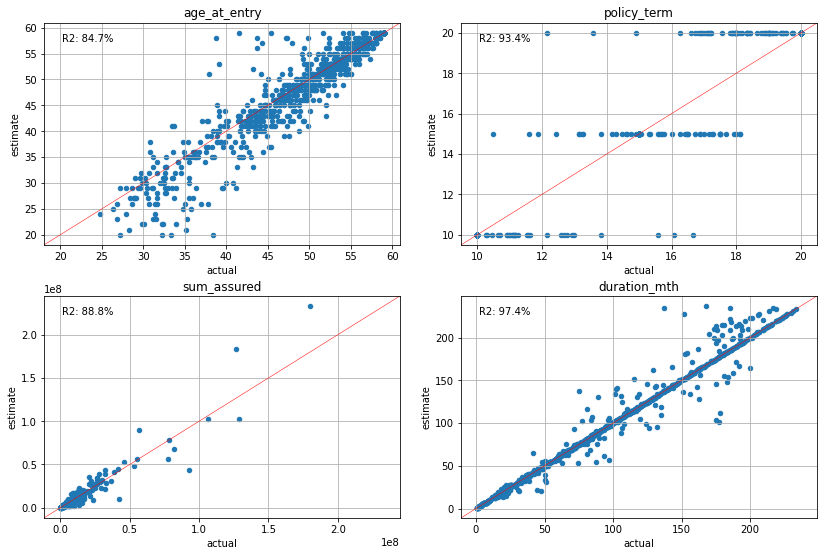

In [57]:
plot_separate_scatter(cluster_cfs.compare(pol_data, agg=mean_attrs), 2, 2)

### Present Value Analysis

The present values of the net cashflows and their components are estimated and compared against the seriatim results for each scenario.

In [58]:
cluster_cfs.compare_total(pvs)

,actual,estimate,error
pv_premiums,4.860639e+07,4.808335e+07,-0.010761
pv_claims,4.331937e+07,4.277110e+07,-0.012656
pv_expenses,2.949823e+06,2.951950e+06,0.000721
pv_commissions,2.748443e+05,2.678388e+05,-0.025489
pv_net_cf,2.062353e+06,2.092461e+06,0.014599


In [59]:
cluster_cfs.compare_total(pvs_lapse50)

,actual,estimate,error
pv_premiums,4.280459e+07,4.229486e+07,-0.011908
pv_claims,3.831786e+07,3.778930e+07,-0.013794
pv_expenses,2.579405e+06,2.584788e+06,0.002087
pv_commissions,2.653036e+05,2.585324e+05,-0.025522
pv_net_cf,1.642024e+06,1.662240e+06,0.012312


In [60]:
cluster_cfs.compare_total(pvs_mort15)

,actual,estimate,error
pv_premiums,4.853083e+07,4.800983e+07,-0.010735
pv_claims,4.973258e+07,4.910429e+07,-0.012633
pv_expenses,2.946908e+06,2.949280e+06,0.000805
pv_commissions,2.748356e+05,2.678307e+05,-0.025488
pv_net_cf,-4.423494e+06,-4.311578e+06,-0.025300


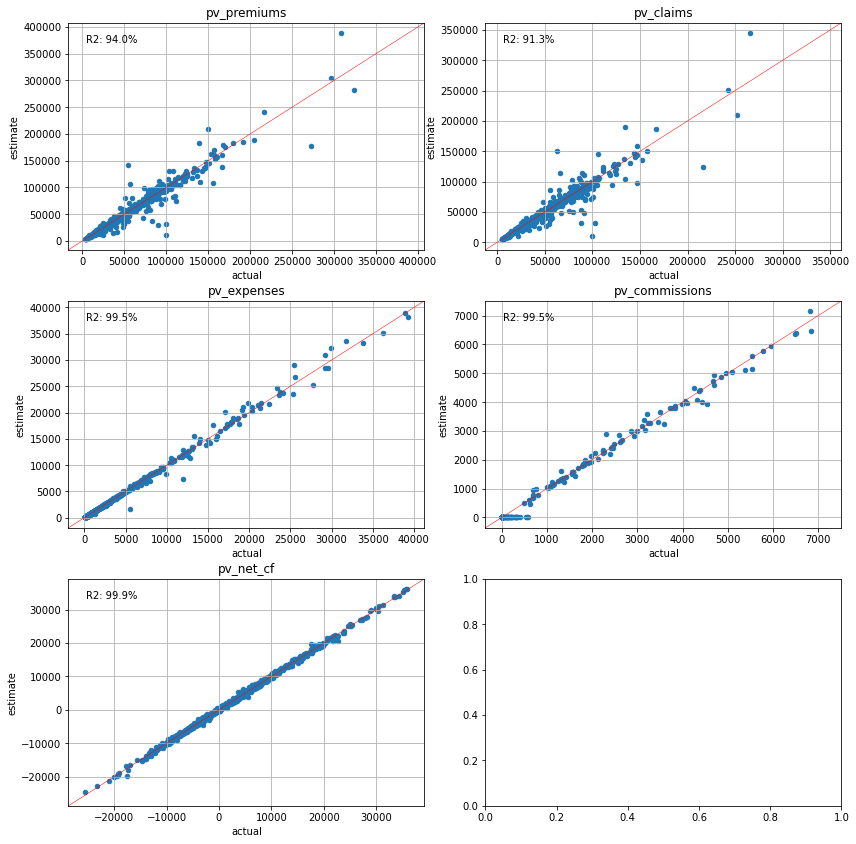

In [61]:
plot_separate_scatter(cluster_cfs.compare(pvs), 3, 2)

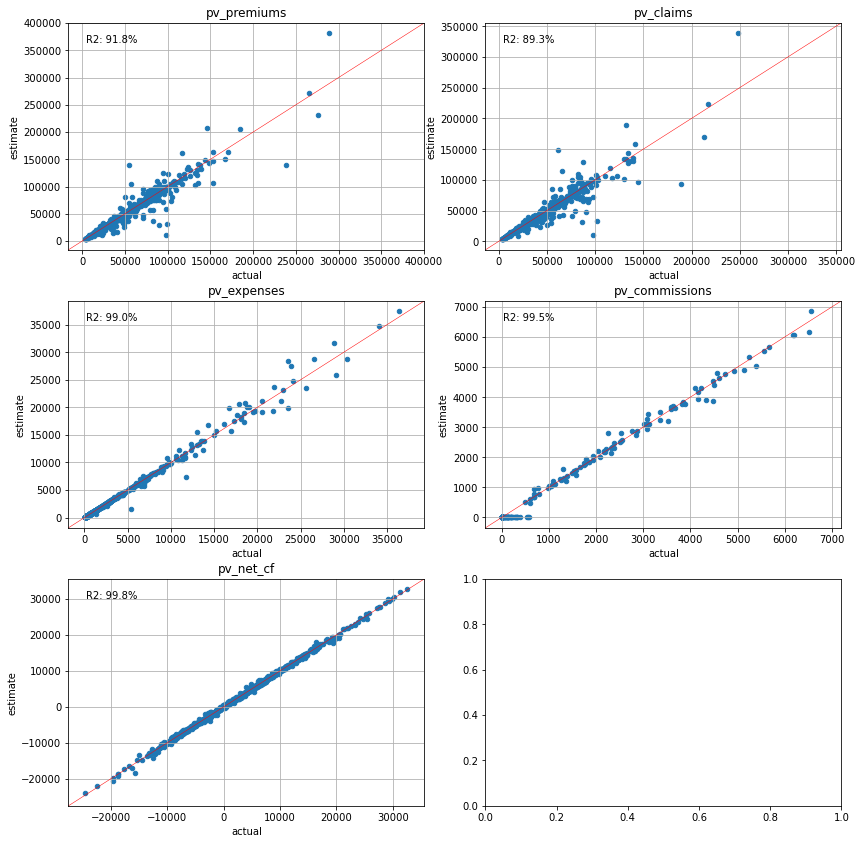

In [62]:
plot_separate_scatter(cluster_cfs.compare(pvs_lapse50), 3, 2)

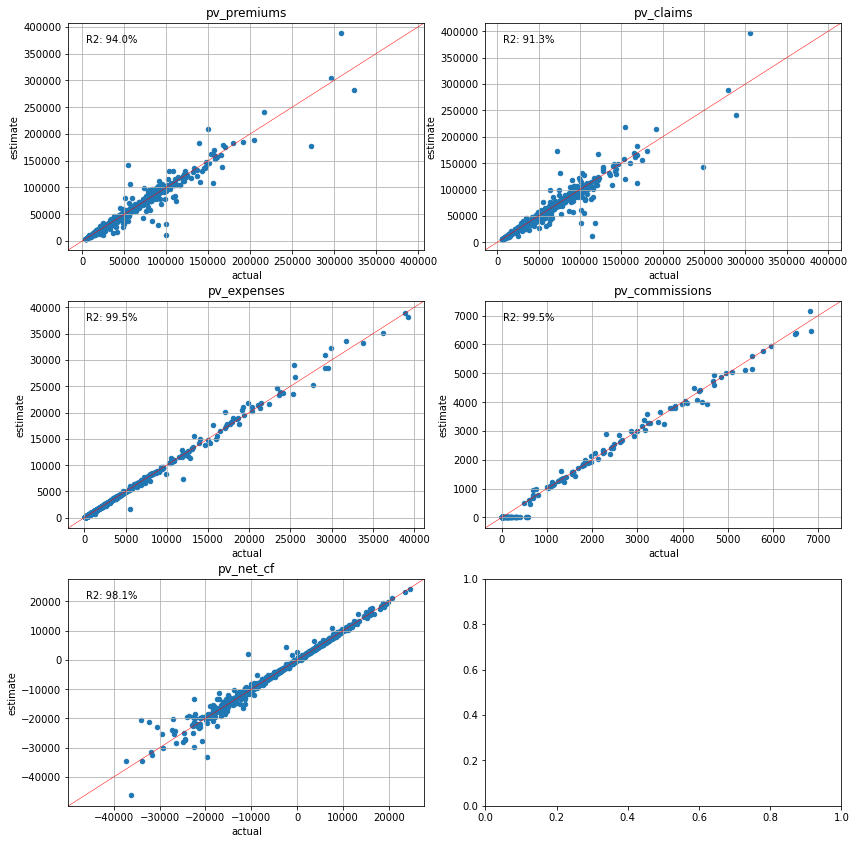

In [63]:
plot_separate_scatter(cluster_cfs.compare(pvs_mort15), 3, 2)

## Policy Attribute Calibration

The next pattern to examine is to use the pollicy attributes as the calibration variables. 
The attibutes needs to be standardized beforehand. 
We use the range standardization method based.

*Reference*
* [Effect of (not) standardizing variables in k-means clustering - Dmitrijs Kass' blog](https://dmitrijskass.netlify.app/2019/10/22/effect-of-not-standardizing-variables-in-k-means-clustering/)

In [64]:
loc_vars = (pol_data- pol_data.min()) / (pol_data.max()- pol_data.min())
loc_vars

,age_at_entry,policy_term,sum_assured,duration_mth
policy_id,,,,
1,0.692308,0.0,0.618182,0.113445
2,0.230769,1.0,0.749495,0.890756
3,0.794872,0.0,0.796970,0.159664
4,0.307692,1.0,0.416162,0.584034
5,0.205128,0.5,0.601010,0.315126
...,...,...,...,...
9996,0.692308,1.0,0.825253,0.701681
9997,0.256410,0.5,0.824242,0.705882
9998,0.641026,1.0,0.780808,0.659664


In [65]:
cluster_attrs = Clusters(loc_vars)

### Cashflow Analysis

In [66]:
cluster_attrs.compare_total(cfs)

,actual,estimate,error
0,1.435932e+06,1.515422e+06,0.055358
1,1.105742e+06,1.078910e+06,-0.024266
2,6.820530e+05,6.763271e+05,-0.008395
3,3.579056e+05,3.592551e+05,0.003771
4,1.450520e+05,1.171398e+05,-0.192429
5,3.343158e+03,2.461364e+03,-0.263761
6,-9.917748e+04,-8.041660e+04,-0.189165
7,-1.636027e+05,-1.620130e+05,-0.009717
8,-2.099648e+05,-2.019957e+05,-0.037954
9,-2.391351e+05,-2.299477e+05,-0.038419


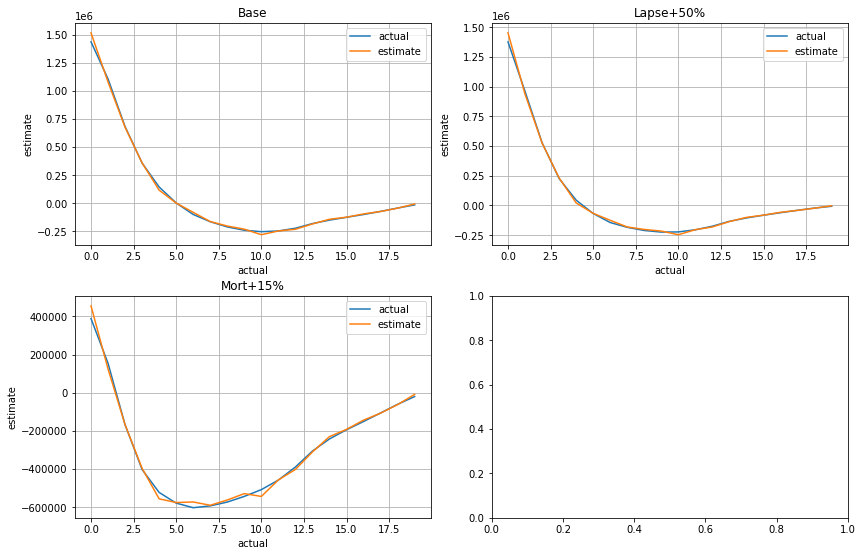

In [67]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_cashflows(ax, cluster_attrs.compare_total(df), title)

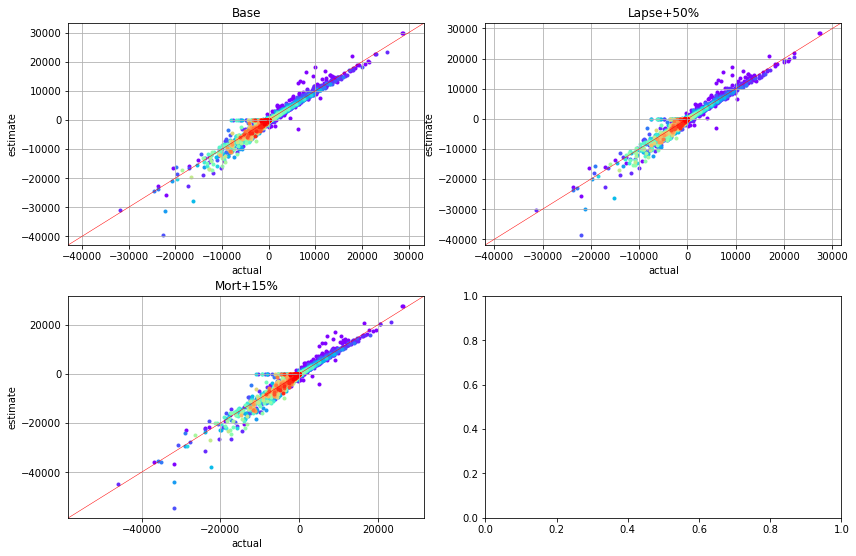

In [68]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_colored_scatter(ax, cluster_attrs.compare(df), title=title)

### Policy Attribute Analysis



In [69]:
cluster_attrs.compare_total(pol_data, agg=mean_attrs)

,actual,estimate,error
age_at_entry,3.937720e+01,3.938370e+01,0.000165
policy_term,1.493600e+01,1.493600e+01,0.000000
sum_assured,5.060517e+09,5.061894e+09,0.000272
duration_mth,8.977470e+01,8.992250e+01,0.001646


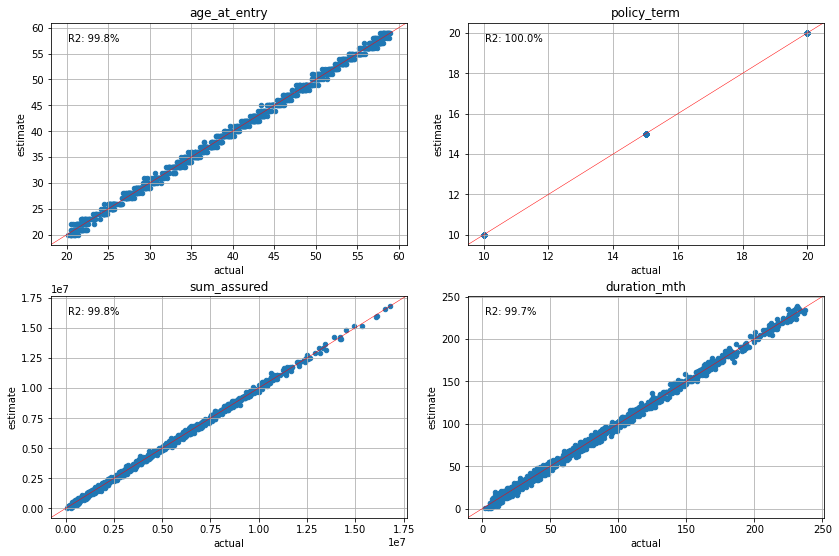

In [70]:
plot_separate_scatter(cluster_attrs.compare(pol_data, agg=mean_attrs), 2, 2)

### Present Value Analysis

In [71]:
cluster_attrs.compare_total(pvs)

,actual,estimate,error
pv_premiums,4.860639e+07,4.847696e+07,-0.002663
pv_claims,4.331937e+07,4.327108e+07,-0.001115
pv_expenses,2.949823e+06,2.954928e+06,0.001731
pv_commissions,2.748443e+05,1.512570e+05,-0.449663
pv_net_cf,2.062353e+06,2.099691e+06,0.018105


In [72]:
cluster_attrs.compare_total(pvs_lapse50)

,actual,estimate,error
pv_premiums,4.280459e+07,4.274185e+07,-0.001466
pv_claims,3.831786e+07,3.831627e+07,-0.000041
pv_expenses,2.579405e+06,2.585876e+06,0.002509
pv_commissions,2.653036e+05,1.467413e+05,-0.446893
pv_net_cf,1.642024e+06,1.692962e+06,0.031021


In [73]:
cluster_attrs.compare_total(pvs_mort15)

,actual,estimate,error
pv_premiums,4.853083e+07,4.840284e+07,-0.002637
pv_claims,4.973258e+07,4.967881e+07,-0.001081
pv_expenses,2.946908e+06,2.952021e+06,0.001735
pv_commissions,2.748356e+05,1.512528e+05,-0.449661
pv_net_cf,-4.423494e+06,-4.379243e+06,-0.010004


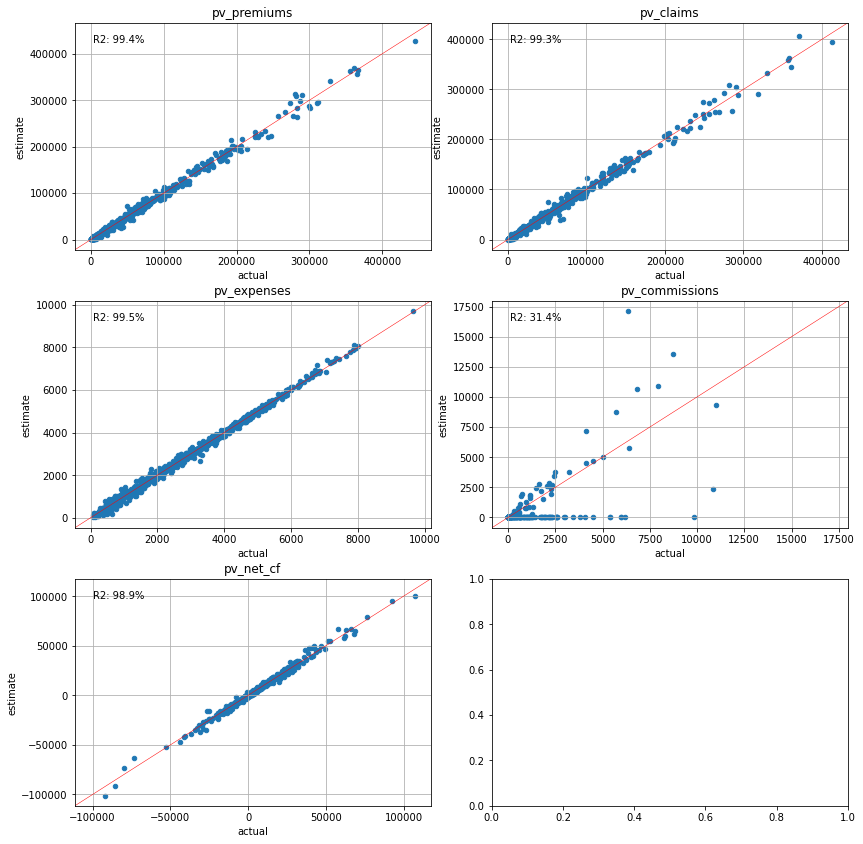

In [74]:
plot_separate_scatter(cluster_attrs.compare(pvs), 3, 2)

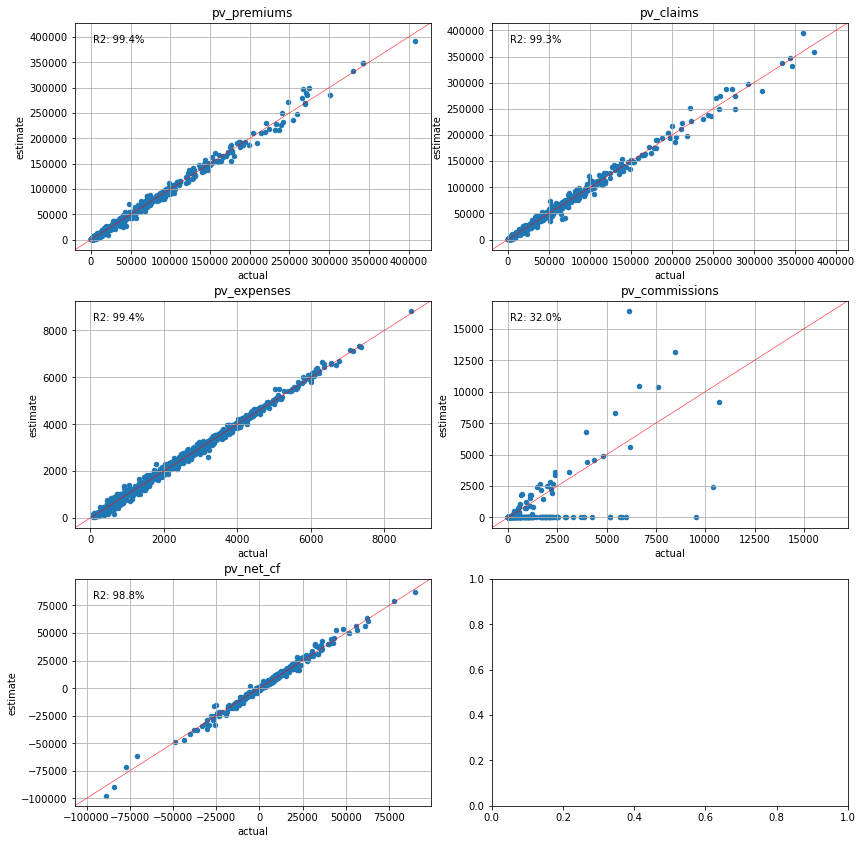

In [75]:
plot_separate_scatter(cluster_attrs.compare(pvs_lapse50), 3, 2)

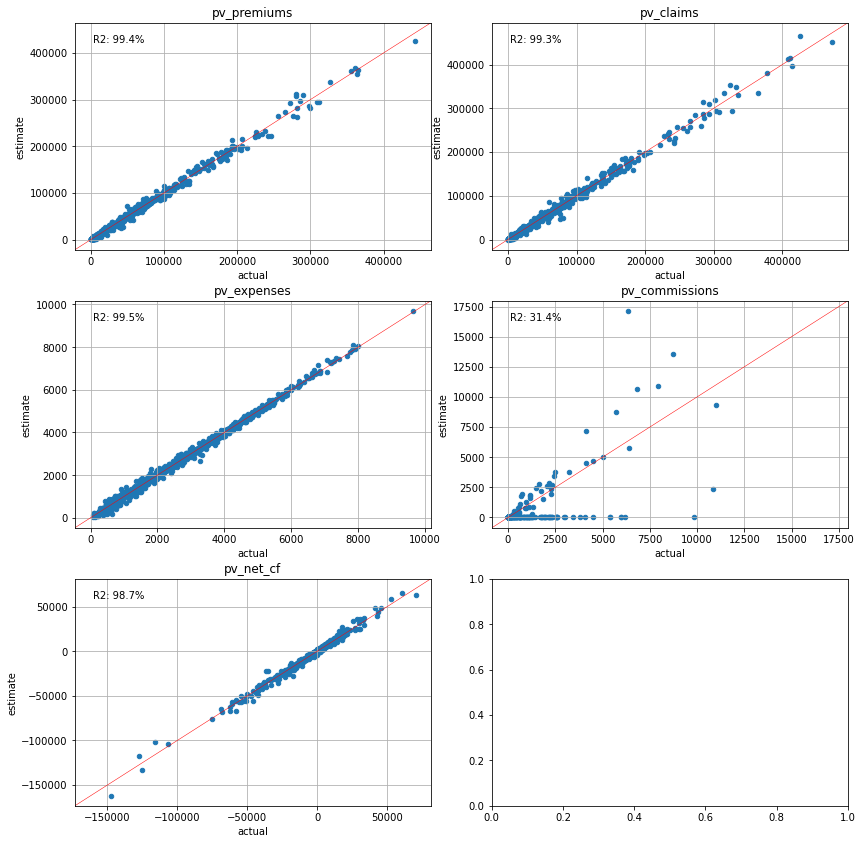

In [76]:
plot_separate_scatter(cluster_attrs.compare(pvs_mort15), 3, 2)

## Present Value Calibration

The last approach is to use the present values of cashflows for the variables. This approach makes sense as present values are most often the final figures to be reported.

In [77]:
cluster_pvs = Clusters(pvs)

### Cashflow Analysis

In [78]:
cluster_pvs.compare_total(cfs)

,actual,estimate,error
0,1.435932e+06,1.460244e+06,0.016931
1,1.105742e+06,1.077397e+06,-0.025635
2,6.820530e+05,6.762972e+05,-0.008439
3,3.579056e+05,3.578314e+05,-0.000207
4,1.450520e+05,1.665679e+05,0.148332
5,3.343158e+03,2.295105e+04,5.865080
6,-9.917748e+04,-8.705404e+04,-0.122240
7,-1.636027e+05,-1.578000e+05,-0.035469
8,-2.099648e+05,-2.047023e+05,-0.025064
9,-2.391351e+05,-2.552303e+05,0.067306


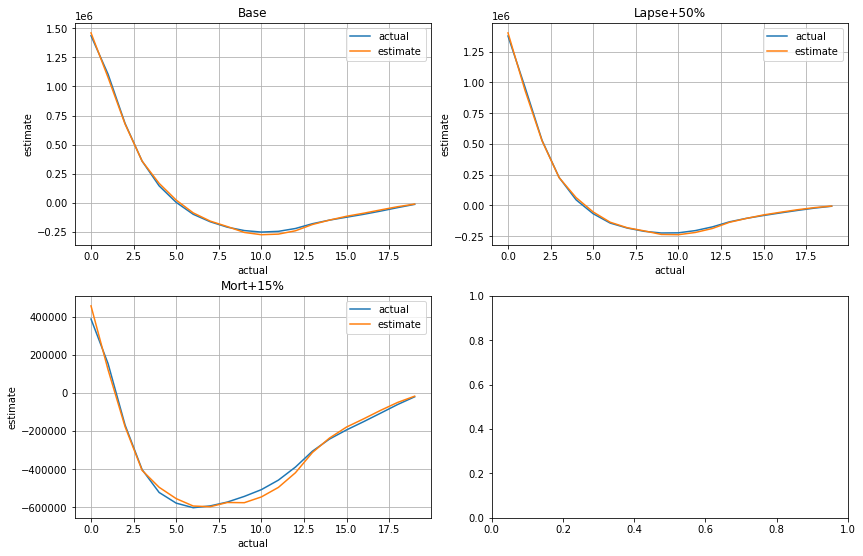

In [79]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_cashflows(ax, cluster_pvs.compare_total(df), title)

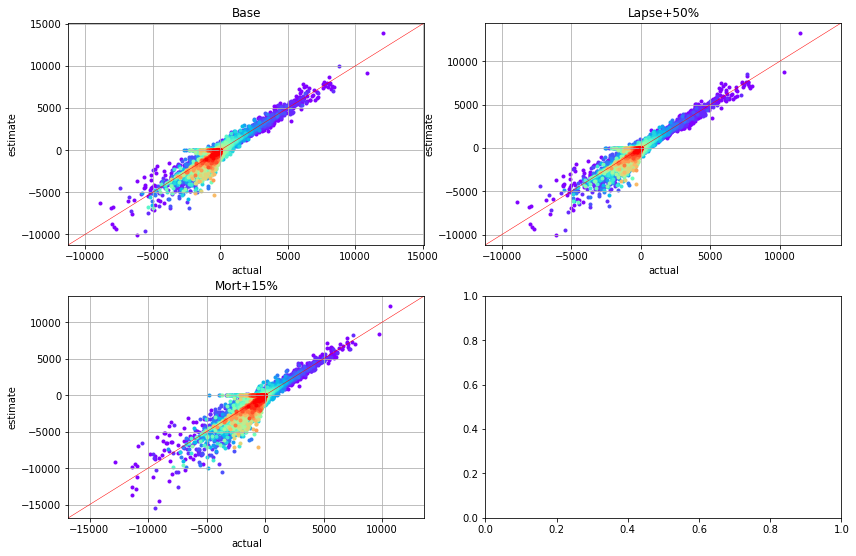

In [80]:
for ax, df, title in zip(generate_subplots(3, (2, 2)), cfs_list, scen_titles):
    plot_colored_scatter(ax, cluster_pvs.compare(df), title=title)

### Policy Attribute Analysis

In [81]:
cluster_pvs.compare_total(pol_data, agg=mean_attrs)

,actual,estimate,error
age_at_entry,3.937720e+01,3.867740e+01,-0.017772
policy_term,1.493600e+01,1.492750e+01,-0.000569
sum_assured,5.060517e+09,4.961158e+09,-0.019634
duration_mth,8.977470e+01,9.021580e+01,0.004913


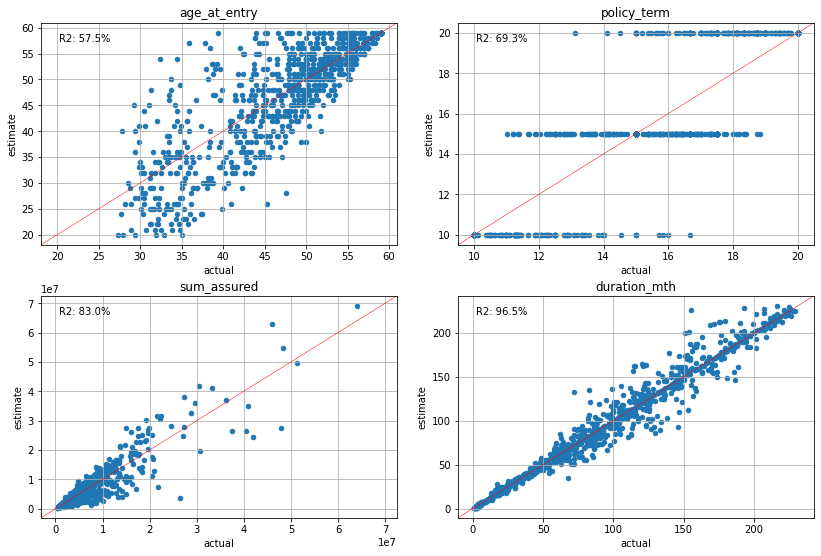

In [82]:
plot_separate_scatter(cluster_pvs.compare(pol_data, agg=mean_attrs), 2, 2)

### Present Value Analysis

In [83]:
cluster_pvs.compare_total(pvs)

,actual,estimate,error
pv_premiums,4.860639e+07,4.861718e+07,0.000222
pv_claims,4.331937e+07,4.331842e+07,-0.000022
pv_expenses,2.949823e+06,2.970547e+06,0.007026
pv_commissions,2.748443e+05,2.608383e+05,-0.050960
pv_net_cf,2.062353e+06,2.067374e+06,0.002435


In [84]:
cluster_pvs.compare_total(pvs_lapse50)

,actual,estimate,error
pv_premiums,4.280459e+07,4.280808e+07,0.000082
pv_claims,3.831786e+07,3.830402e+07,-0.000361
pv_expenses,2.579405e+06,2.606721e+06,0.010590
pv_commissions,2.653036e+05,2.516164e+05,-0.051591
pv_net_cf,1.642024e+06,1.645724e+06,0.002253


In [85]:
cluster_pvs.compare_total(pvs_mort15)

,actual,estimate,error
pv_premiums,4.853083e+07,4.853956e+07,0.000180
pv_claims,4.973258e+07,4.972895e+07,-0.000073
pv_expenses,2.946908e+06,2.967635e+06,0.007033
pv_commissions,2.748356e+05,2.608301e+05,-0.050960
pv_net_cf,-4.423494e+06,-4.417858e+06,-0.001274


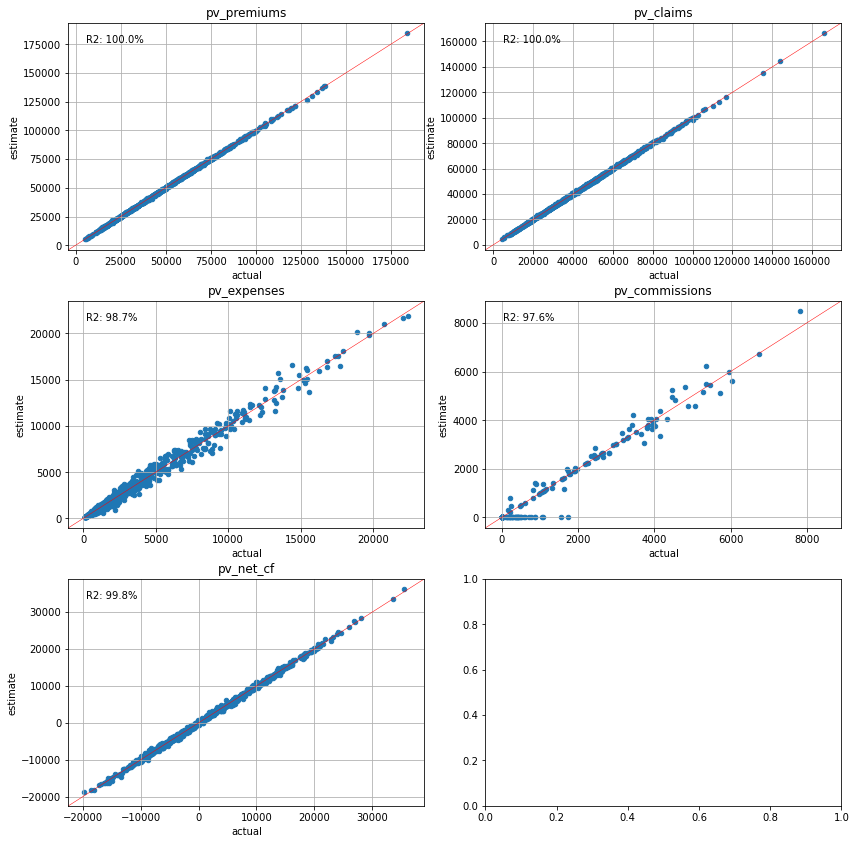

In [86]:
plot_separate_scatter(cluster_pvs.compare(pvs), 3, 2)

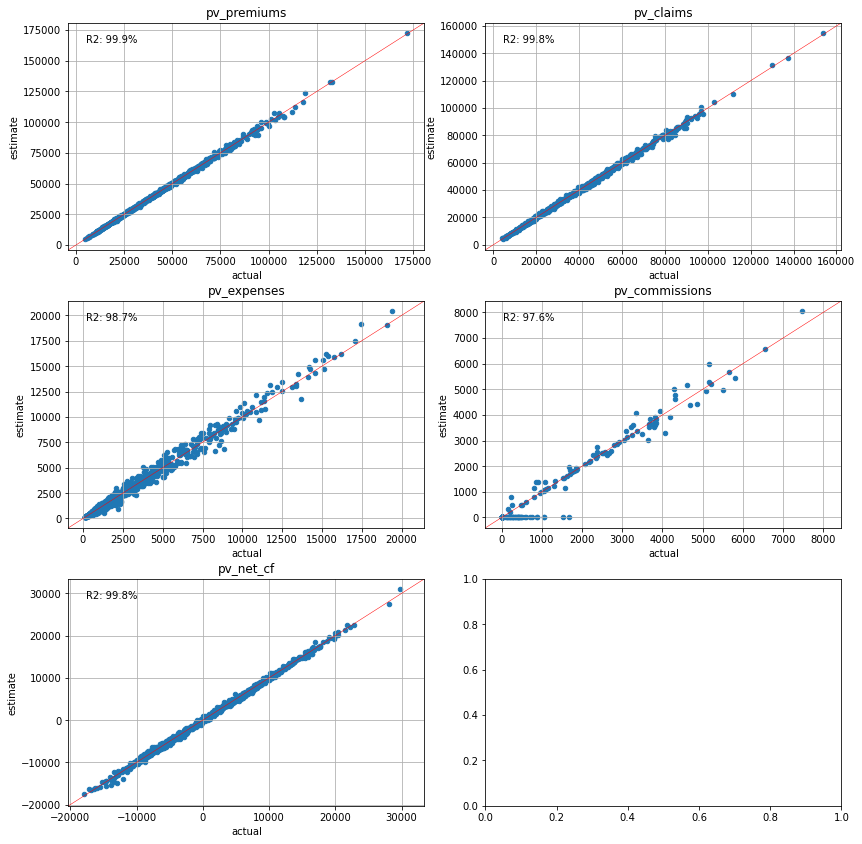

In [87]:
plot_separate_scatter(cluster_pvs.compare(pvs_lapse50), 3, 2)

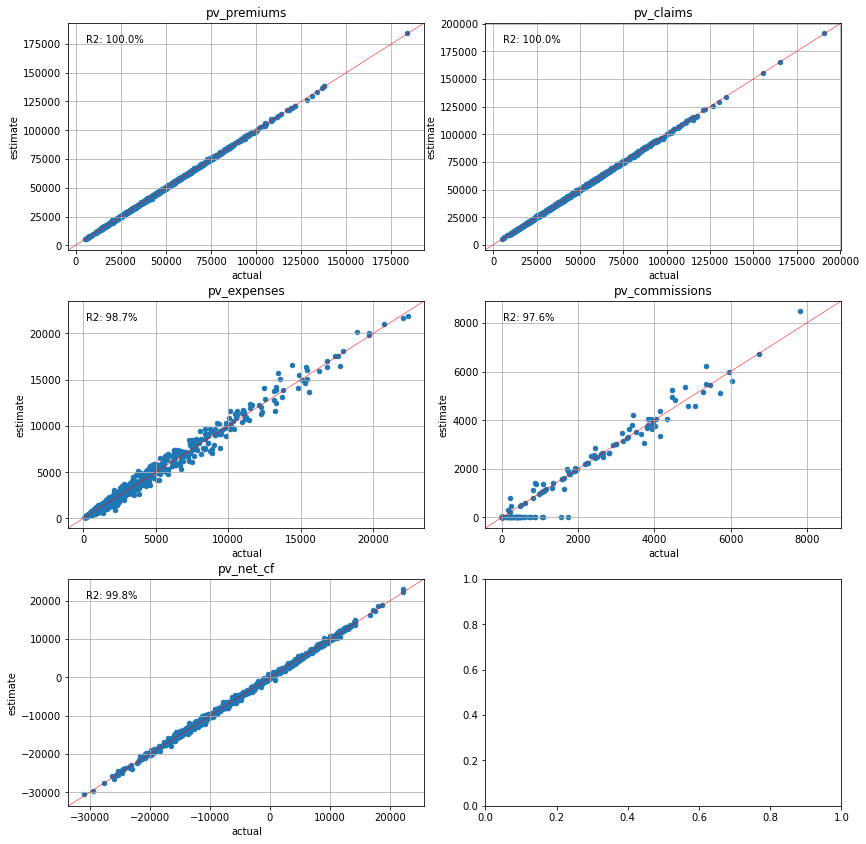

In [88]:
plot_separate_scatter(cluster_pvs.compare(pvs_mort15), 3, 2)

## Conclustion

As expected, the results are highly dependent on the choice of calibration variables. The variables chosen for calibration are more accurately estimated by the proxy portfolio than others. In practice, the present values of cashflows are often the most important metrics. Our exercise shows that choosing the present values of net cashflows for the variables estimates the seriatim results best, with error percentages below 1% in all the scenarios.